In [384]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from math import sqrt

import warnings
warnings.filterwarnings('ignore')

# Recommendation systems

A recommender system is a simple algorithm whose aim is to provide the most relevant information to a user by discovering patterns in a dataset. The algorithm rates the items and shows the user the items that they would rate highly.

## Importing Dependencies

In [385]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from math import sqrt

## Importing dataset

In [386]:
# user_id / item_id rating dataset
ratings = pd.read_csv("ratings_dataset.csv")

# Movies titles dataset
movies = pd.read_csv("Movie_Id_Titles.csv")
ratings.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


## Explore the dataset

In [387]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100003 non-null  int64
 1   item_id    100003 non-null  int64
 2   rating     100003 non-null  int64
 3   timestamp  100003 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [388]:
users = ratings["user_id"].unique()
users.shape

(944,)

### Ratings distrubution

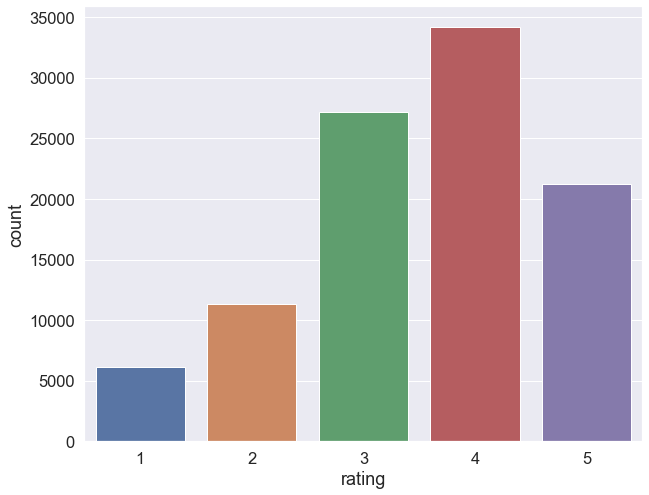

In [389]:
plt.figure(figsize = ( 10,8))
sns.countplot(data = ratings, x = 'rating')
plt.show()

### Most popular items based on the rating

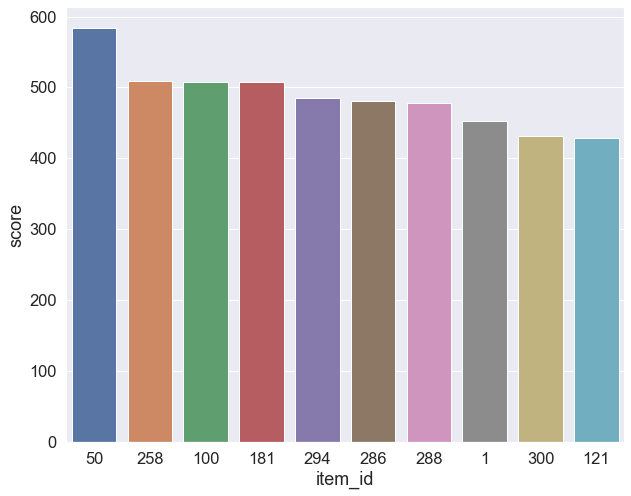

In [390]:
ratings_grouped = ratings.groupby(['item_id']).agg({'user_id': 'count'}).reset_index()
ratings_grouped.rename(columns = {'user_id': 'score'},inplace=True)

#Sort the movies based upon recommendation score
ratings_sort = ratings_grouped.sort_values(['score', 'item_id'], ascending = [0,1]).head(10)

plt.figure(figsize = ( 10,8))
sns.barplot(data = ratings_sort.head(10), x = 'item_id', y='score', order=ratings_sort.item_id)
plt.show()


## Build the movie recommender

In the next part we are going to build two types of recommenders, Popularity based and Collaborative based filtering recommenders.
Each class of these recommednders will contain the following methdos:
- Class constructor
- Fit: this method used to train the model based on its type
- recommed: this method will return and plot the top n in our suggestion list
- evaluate: this method is usefull for evaluating our model using root-mean-square error (RMSE) 

In [398]:
# Split the dataset into trainset and testset
train_data, test_data = train_test_split(ratings, test_size=.3, random_state=10)

## Popularity based filtering

As the name suggests Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

For our case we are ranking the moved rated movies and return the top n

In [392]:
class popularity_based_recommender_model():
    def __init__(self, train_data, test_data, user_id, item_id):
        self.train_data = train_data
        self.test_data = test_data
        self.user_id = user_id
        self.item_id = item_id
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def fit(self):
        # Get a count of user_ids for each unique movie as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the movies based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        # Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        # Get the top 20 recommendations
        self.popularity_recommendations = train_data_sort.head(20)

    # Use the popularity based recommender system model to make recommendations
    def recommend(self, user_id, n=5):    
        user_recommendations = self.popularity_recommendations
        
        # Filter movies that are not rated by the user
        movies_already_rated_by_user = self.train_data[self.train_data[self.user_id] == user_id][self.item_id]        
        user_recommendations = user_recommendations[~user_recommendations[self.item_id].isin(movies_already_rated_by_user)]
        
        # Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        # Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols].head(n)   
        user_recommendations["movie_title"] = user_recommendations['item_id'].map(movies.set_index('item_id')['title'])
  
        # plot the recommendation and return the results
        self.plot(user_recommendations)
        return user_recommendations
    
    def plot(self, user_recommendations):
        sns.set_style("whitegrid")
        plt.figure(figsize=(20, 10))
        sns.set(font_scale=1.5)
        suggested_items = sns.barplot(x='score', y="movie_title", data=user_recommendations ,linewidth=1,edgecolor=".2",palette="Blues",saturation=1)
        suggested_items.set_title('List of the suggested movies based on their popularity')
        suggested_items.set(xlabel='Total rating', ylabel='Titles')
        plt.show()

    # Evaluate the model using root-mean-square error (RMSE) 
    def predict_evaluate(self):        
        ratings = pd.DataFrame(self.train_data.groupby(self.item_id)['rating'].mean())
        
        pred_ratings = [];            
        for data in self.test_data.values:
            if(data[1] in (ratings.index)):
                pred_ratings.append(ratings.loc[data[1]])
            else:
                pred_ratings.append(0)
        
        mse = mean_squared_error(self.test_data['rating'], pred_ratings)
        rmse = sqrt(mse)
        return rmse

In [393]:
# Calling the model
popularity_recommender = popularity_based_recommender_model(train_data=train_data, test_data=test_data, user_id="user_id", item_id="item_id")

# Fitting the model
popularity_recommender.fit()

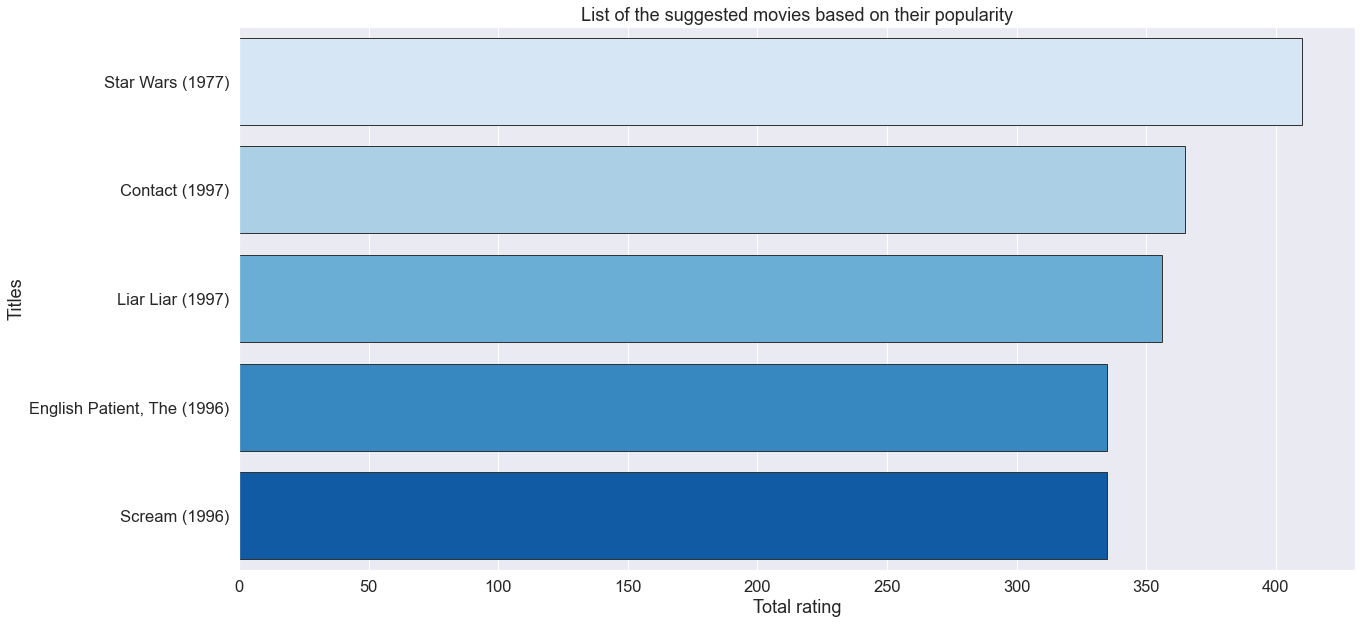

,user_id,item_id,score,Rank,movie_title
49,1,50,410,1.0,Star Wars (1977)
257,1,258,365,2.0,Contact (1997)
293,1,294,356,3.0,Liar Liar (1997)
285,1,286,335,6.0,"English Patient, The (1996)"
287,1,288,335,7.0,Scream (1996)


In [394]:
# Get the movies recommendation for the user with the 1
# for popularity recommendation we will always get the same results since it's based the movies popularity
result_pop = popularity_recommender.recommend(1)
result_pop

## Collaborative filtering based recommender

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.

In [395]:
class collaborative_filtering_recommender_model():
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
        self.recommendations = None
        self.user_item_matrix = None
        self.ratings = None
        
    #Create the collaboration filtering correlation based recommender system model
    def fit(self):
        # Get a mean value for items based on user's ratings
        train_data_grouped = pd.DataFrame(train_data.groupby('item_id')['rating'].mean())
        train_data_grouped['rating_count'] = pd.DataFrame(train_data.groupby('item_id')['rating'].count())

        # Create factorization matrix
        user_movie_matrix = train_data.pivot_table(index='user_id', columns='item_id', values='rating')

        self.user_item_matrix = user_movie_matrix
        self.ratings = train_data_grouped

    #Use the collaboration filtering correlation based recommender system model to make recommendations
    def recommend(self, user_id, threshold = 30):    
        user_item_matrix = self.user_item_matrix
        ratings = self.ratings
        
        # Get user's rating vector
        user_vector = user_item_matrix[user_id]

        # Calculate the correlation between user_rating_vector and other vectors
        corr_matrix = user_item_matrix.corrwith(user_vector)
        corr_movies = pd.DataFrame(corr_matrix, columns=['correlation'])        
        corr_movies.dropna(inplace=True)

        # Join the corr table with ratings 
        corr_movies = corr_movies.join(ratings['rating_count'], how='left', lsuffix='_left', rsuffix='_right')

        # Filter the recommendation based on the rating counts
        user_recommendations = corr_movies[corr_movies['rating_count']>threshold].sort_values('correlation', ascending=False)
        user_recommendations["item_id"] = user_recommendations.index

        # #Sort the movies based upon recommendation score
        # train_data_sort = user_recommendations.sort_values(['correlation'], ascending = 0)

        # Filter the movies that has been watched by the user
        user_recommendations = user_recommendations.query("correlation < 1")

        # Sort the suggestion list based on their correlation
        user_recommendations = user_recommendations.sort_values('correlation', ascending=0).head(5)

        # Add novie titles to the suggestions
        user_recommendations["movie_title"] = user_recommendations['item_id'].map(movies.set_index('item_id')['title'])

        #Generate a recommendation rank based upon score
        user_recommendations['Rank'] = user_recommendations['correlation'].rank(ascending=0, method='first')

        self.plot(user_recommendations)
        return user_recommendations
    
    def plot(self, user_recommendations):
        sns.set_style("whitegrid")
        plt.figure(figsize=(20, 10))
        sns.set(font_scale=1.5)
        suggested_items = sns.barplot(x='correlation', y="movie_title", data=user_recommendations ,linewidth=1,edgecolor=".2",palette="Blues",saturation=1)
        suggested_items.set_title('List of the suggested movies based on collaboration filtering')
        suggested_items.set(xlabel='Correlation', ylabel='Titles')
        plt.show()

        

        
    def predict_evaluate(self):        
        ratings = pd.DataFrame(self.train_data.groupby('item_id')['rating'].mean())
        
        pred_ratings = [];            
        for data in self.test_data.values:
            if(data[1] in (ratings.index)):
                pred_ratings.append(ratings.loc[data[1]])
            else:
                pred_ratings.append(0)
        
        mse = mean_squared_error(self.test_data['rating'].fillna(0), pred_ratings.fillna(0))
        rmse = sqrt(mse)
        return rmse

In [396]:
# Fire the collaborative filtering recommender and train it with our trainset
collaboration_filtering_recommender = collaborative_filtering_recommender_model(train_data=train_data, test_data=test_data)
collaboration_filtering_recommender.fit()

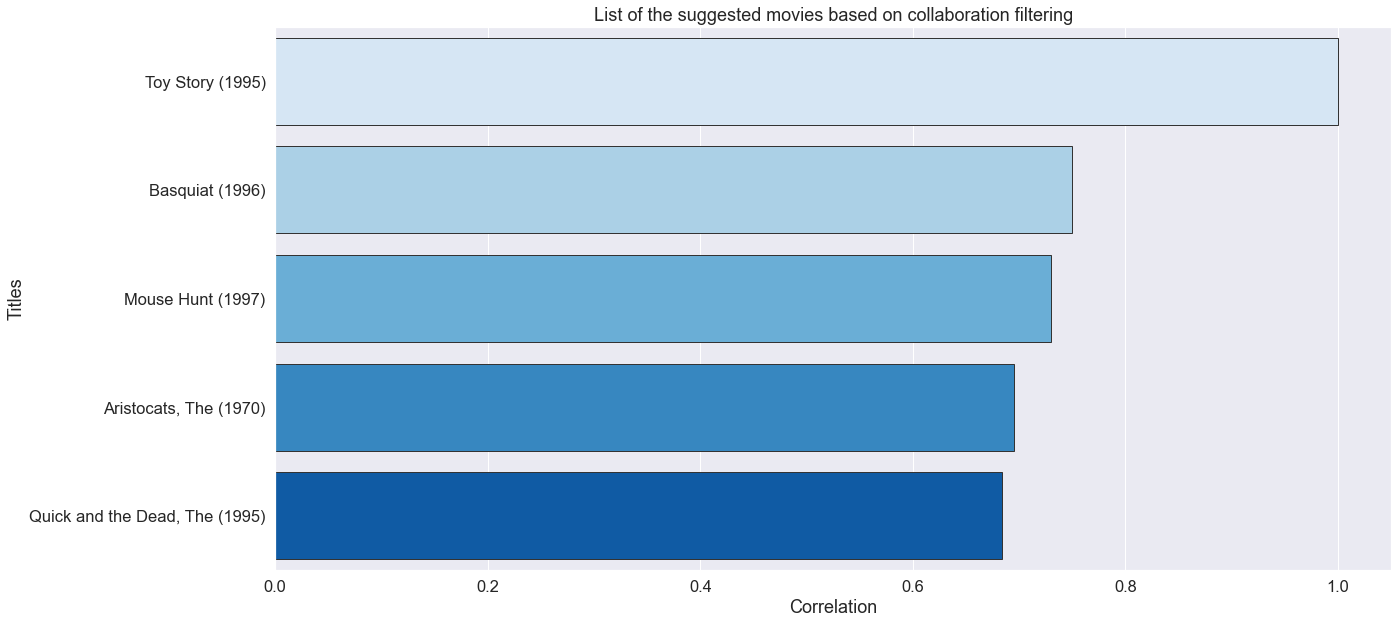

,correlation,rating_count,item_id,movie_title,Rank
item_id,,,,,
1,1.000000,311,1,Toy Story (1995),1.0
1010,0.749869,34,1010,Basquiat (1996),2.0
539,0.730341,36,539,Mouse Hunt (1997),3.0
102,0.695539,39,102,"Aristocats, The (1970)",4.0
562,0.683389,36,562,"Quick and the Dead, The (1995)",5.0


In [397]:
# Get the top 5 suggestion for this user based on the collaborative filtering
result_colab = collaboration_filtering_recommender.recommend(1)
result_colab

------------------------------
Thank you for reading, till next time :)